# LOGISTIC REGRESSION + PAILLIER HOMOMORPHIC ENCRYPTION

In [1]:
!export PATH=/Library/TeX/texbin:$PATH


## GATHERING DATA

In [41]:
import os

def extract_emails(directory, output_file):
    with open(output_file, 'w', encoding='utf-8') as out_file:
        for root, _, files in os.walk(directory):
            for file in files:
                # Process text files, eml files, or files without an extension
                if file.endswith('.txt') or file.endswith('.eml') or not os.path.splitext(file)[1]:
                    file_path = os.path.join(root, file)
                    try:
                        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                            content = f.read()
                            out_file.write(content + '\n\n')  # Separate emails by two newlines
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")

# Paths to directories
ham_dir = 'enron/ham'
spam_dir = 'enron/spam'

# Output files
ham_output_file = 'enron/ham.txt'
spam_output_file = 'enron/spam.txt'

# Extract emails
extract_emails(ham_dir, ham_output_file)
extract_emails(spam_dir, spam_output_file)

print("Extraction complete.")


Extraction complete.


## SIMPLE LOGISTIC REGRESSION


In [10]:
import numpy as np
from collections import Counter
import random
import sys
import chardet

np.random.seed(12345)

print("Importing dataset from disk...")

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

# Detect encoding for spam.txt
encoding_spam = detect_encoding('spam.txt')
with open('spam.txt', 'r', encoding=encoding_spam, errors='replace') as f:
    raw = f.readlines()

spam = [row[:-2].split(" ") for row in raw]

# Detect encoding for ham.txt
encoding_ham = detect_encoding('ham.txt')
with open('ham.txt', 'r', encoding=encoding_ham, errors='replace') as f:
    raw = f.readlines()

ham = [row[:-2].split(" ") for row in raw]

class LogisticRegression(object):
    
    def __init__(self, positives, negatives, iterations=10, alpha=0.01, regularization_strength=0.01):
        
        self.maxweight = 10
        self.alpha = alpha
        self.regularization_strength = regularization_strength
        
        # Create vocabulary
        cnts = Counter()
        for email in (positives + negatives):
            for word in email:
                cnts[word] += 1
        
        vocab = list(cnts.keys())
        self.word2index = {word: i for i, word in enumerate(vocab)}
    
        # Initialize weights
        self.weights = (np.random.rand(len(vocab)) - 0.5) * 0.1
        
        # Train model
        self.train(positives, negatives, iterations=iterations)
    
    def train(self, positives, negatives, iterations=10):
        
        for iter in range(iterations):
            error = 0
            n = 0
            for i in range(max(len(positives), len(negatives))):
                error += np.abs(self.learn(positives[i % len(positives)], 1))
                error += np.abs(self.learn(negatives[i % len(negatives)], 0))
                n += 2

            print("Iter:" + str(iter) + " Loss:" + str(error / float(n)))
    
    @staticmethod
    def softmax(x):
        x = np.clip(x, -500, 500)  # Clip values to avoid overflow
        return 1 / (1 + np.exp(-x))
    
    def predict(self, email):
        return self.unencrypted_predict(email)
    
    def unencrypted_predict(self, email):
        pred = 0
        for word in email:
            pred += self.weights[self.word2index[word]]
        pred = self.softmax(pred)
        return pred

    def learn(self, email, target):
        pred = self.predict(email)
        delta = (pred - target)
        for word in email:
            self.weights[self.word2index[word]] -= (delta * self.alpha + self.regularization_strength * self.weights[self.word2index[word]])
        return delta

model = LogisticRegression(spam[0:-1000], ham[0:-1000], iterations=20, alpha=0.01, regularization_strength=0.005)

# Evaluate the model
fp = 0
tn = 0
tp = 0
fn = 0

for i, h in enumerate(ham[-1000:]):
    pred = model.predict(h)
    if pred < 0.5:
        tn += 1
    else:
        fp += 1

    if i % 10 == 0:
        sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * tn / float(tn + fp))[0:6])

for i, h in enumerate(spam[-1000:]):
    pred = model.predict(h)
    if pred > 0.5:
        tp += 1
    else:
        fn += 1

    if i % 10 == 0:
        sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])

sys.stdout.write('\r I:' + str(tn + tp + fn + fp) + " % Correct:" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])

print("\n Accuracy: %" + str(100 * (tn + tp) / float(tn + tp + fn + fp))[0:6])
print("False Positives: %" + str(100 * fp / float(tp + fp))[0:4] + "    <- privacy violation level")
print("False Negatives: %" + str(100 * fn / float(tn + fn))[0:4] + "   <- security risk level")


Importing dataset from disk...
Iter:0 Loss:0.1418565838862508
Iter:1 Loss:0.1159124479776207
Iter:2 Loss:0.11007672910511375
Iter:3 Loss:0.10665691746145255
Iter:4 Loss:0.10412171061464175
Iter:5 Loss:0.10202175002694532
Iter:6 Loss:0.10078361353158154
Iter:7 Loss:0.09973163654990577
Iter:8 Loss:0.09914064915691775
Iter:9 Loss:0.09824559484017459
Iter:10 Loss:0.09769536162716529
Iter:11 Loss:0.09697567747573058
Iter:12 Loss:0.09684459533264063
Iter:13 Loss:0.09674045756105
Iter:14 Loss:0.09605884690921715
Iter:15 Loss:0.09590132617151204
Iter:16 Loss:0.09578045455963016
Iter:17 Loss:0.09500135219551235
Iter:18 Loss:0.09517674220316232
Iter:19 Loss:0.09461852895063669
 I:2000 % Correct:99.497
 Accuracy: %99.4
False Positives: %0.89    <- privacy violation level
False Negatives: %0.30   <- security risk level


## STANDALONE PAILLIER HOMOMORPHIC ENCRYPTION

In [12]:
import math
import libnum

# Function to compute modular inverse
def mod_inverse(x, n):
    return pow(x, -1, n)

# L function for decryption
def L(x, n):
    return (x - 1) // n

# Paillier key generation using libnum for prime generation
def generate_keys(bit_length=512):
    # Generate two large prime numbers p and q using libnum
    p = libnum.generate_prime(bit_length // 2)
    q = libnum.generate_prime(bit_length // 2)

    n = p * q  # n = p * q
    n_sq = n * n  # n^2 for the modulus in encryption

    # λ (lambda) = lcm(p-1, q-1)
    lambda_param = (p - 1) * (q - 1) // math.gcd(p - 1, q - 1)

    # g can be any number (usually n+1)
    g = n + 1

    # µ = (L(g^λ mod n^2))^(-1) mod n
    mu = mod_inverse(L(pow(g, lambda_param, n_sq), n), n)

    public_key = (n, g)
    private_key = (lambda_param, mu)

    return public_key, private_key

# Custom EncryptedNumber class to mimic object-like string representation
class EncryptedNumber:
    def __init__(self, ciphertext):
        self.ciphertext = ciphertext

    def __str__(self):
        # This returns a string similar to an object representation
        return f"<EncryptedNumber object at {hex(id(self))}>"

# Paillier encryption
def encrypt(public_key, plaintext):
    n, g = public_key
    n_sq = n * n

    # Choose random r where 1 <= r < n
    r = libnum.randint_bits(n.bit_length() - 1) % n

    # Encryption formula: c = g^m * r^n mod n^2
    ciphertext = (pow(g, plaintext, n_sq) * pow(r, n, n_sq)) % n_sq
    return EncryptedNumber(ciphertext)  # Wrap ciphertext in EncryptedNumber class

# Paillier decryption
def decrypt(private_key, public_key, encrypted_number):
    n, g = public_key
    lambda_param, mu = private_key
    n_sq = n * n

    # Extract the actual ciphertext from the EncryptedNumber object
    ciphertext = encrypted_number.ciphertext

    # Decryption formula: m = L(c^λ mod n^2) * µ mod n
    x = pow(ciphertext, lambda_param, n_sq)
    plaintext = (L(x, n) * mu) % n
    return plaintext

# Homomorphic addition of two ciphertexts
def homomorphic_add(public_key, c1, c2):
    n, _ = public_key
    n_sq = n * n

    # Homomorphic addition: c3 = (c1 * c2) mod n^2
    return EncryptedNumber((c1.ciphertext * c2.ciphertext) % n_sq)

# Example usage:
if __name__ == "__main__":
    # Key generation (512-bit security)
    public_key, private_key = generate_keys(bit_length=512)

    # Encrypt two messages
    m1 = 42
    m2 = 23
    print(f"Original messages: {m1}, {m2}")

    c1 = encrypt(public_key, m1)
    c2 = encrypt(public_key, m2)
    print(f"Encrypted messages: {c1}, {c2}")

    # Homomorphic addition of encrypted messages
    c3 = homomorphic_add(public_key, c1, c2)
    print(f"Encrypted sum: {c3}")

    # Decrypt the sum
    decrypted_sum = decrypt(private_key, public_key, c3)
    print(f"Decrypted sum: {decrypted_sum}")


Original messages: 42, 23
Encrypted messages: <EncryptedNumber object at 0x10f0df980>, <EncryptedNumber object at 0x10f261b50>
Encrypted sum: <EncryptedNumber object at 0x10aefb620>
Decrypted sum: 65


## COMPLETE LOGISTIC REGRESSION + PAILLIER HOMOMORPHIC ENCRYPTION

In [82]:
import numpy as np
from collections import Counter
import chardet
import math
import re
import libnum
import random

np.random.seed(12345)

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'Subject:', '', text)
    return text
    
def load_data(file_path):
    print(f"Detecting Encoding for {file_path}...")
    encoding = detect_encoding(file_path)
    print(f"Encoding detected: {encoding}\n")

    print(file_path, " : ", encoding) 
    with open(file_path, 'r', encoding=encoding, errors='replace') as f:
        raw = f.readlines()
    print(f"Dataset '{file_path}' loaded successfully with {len(raw)} records.\n")
    return [[word for word in clean_text(row).split() if word.strip()] for row in raw]

spam = load_data('spam.txt')
ham = load_data('ham.txt')

def mod_inverse(x, n):
    return pow(x, -1, n)

def L(x, n):
    return (x - 1) // n

def generate_keys(bit_length=256):
    print("Generating keys, please wait...")

    p = libnum.generate_prime(bit_length // 2)
    q = libnum.generate_prime(bit_length // 2)
    n = p * q
    n_sq = n * n
    lambda_param = (p - 1) * (q - 1) // math.gcd(p - 1, q - 1)
    g = n + 1
    mu = mod_inverse(L(pow(g, lambda_param, n_sq), n), n)
    print(f"Keys generated successfully! (bit length: {bit_length})\n")

    public_key = (n, g)
    private_key = (lambda_param, mu)
    return public_key, private_key

split_idx_spam = int(0.8 * len(spam))
split_idx_ham = int(0.8 * len(ham))

train_spam, val_spam = spam[:split_idx_spam], spam[split_idx_spam:]
train_ham, val_ham = ham[:split_idx_ham], ham[split_idx_ham:]

class EncryptedNumber:
    def __init__(self, ciphertext):
        self.ciphertext = ciphertext

def encrypt(public_key, plaintext, scaling_factor=1000):
    n, g = public_key
    n_sq = n * n
    r = libnum.randint_bits(n.bit_length() - 1) % n
    ciphertext = (pow(g, int(plaintext * scaling_factor), n_sq) * pow(r, n, n_sq)) % n_sq
    return EncryptedNumber(ciphertext)

def decrypt(private_key, public_key, encrypted_number, scaling_factor=1000):
    n, g = public_key
    lambda_param, mu = private_key
    n_sq = n * n
    ciphertext = encrypted_number.ciphertext
    x = pow(ciphertext, lambda_param, n_sq)
    plaintext = (L(x, n) * mu) % n
    return plaintext / scaling_factor

def homomorphic_add(public_key, c1, c2):
    n, _ = public_key
    n_sq = n * n
    return EncryptedNumber((c1.ciphertext * c2.ciphertext) % n_sq)

class LogisticRegression:
    def __init__(self, positives, negatives, public_key, val_pos, val_neg, iterations=10, alpha=0.01, regularization_strength=0.05, weight_scale=1e3, noise_factor=0.005):
        self.alpha = alpha
        self.regularization_strength = regularization_strength
        self.pubkey = public_key
        self.weight_scale = weight_scale
        self.noise_factor = noise_factor  # New noise factor

        print(f"Initializing Logistic Regression model...")
        cnts = Counter()
        for email in (positives + negatives):
            cnts.update(email)

        vocab = list(cnts.keys())
        self.word2index = {word: i for i, word in enumerate(vocab)}

        self.training_losses = []
        self.validation_losses = []
        self.training_accuracies = []
        self.validation_accuracies = []


        # Initialize weights as in target
        self.weights = (np.random.rand(len(vocab)) - 0.5) * 0.1

        self.train(positives, negatives, val_pos, val_neg, iterations=iterations)

        # Encrypt weights after training
        self.encrypted_weights = [encrypt(self.pubkey, int(weight)) for weight in self.weights]

    def train(self, positives, negatives, val_pos, val_neg, iterations=10):
        for iteration in range(iterations):
            train_loss = 0
            train_correct = 0  # Counter for correct training predictions
            n = 0
    
            for i in range(max(len(positives), len(negatives))):
                # Apply noise to target labels
                noisy_target_pos = 1 if random.random() > self.noise_factor else 0
                noisy_target_neg = 0 if random.random() > self.noise_factor else 1
    
                train_loss += np.abs(self.learn(positives[i % len(positives)], noisy_target_pos))
                train_loss += np.abs(self.learn(negatives[i % len(negatives)], noisy_target_neg))
    
                # Check predictions for training accuracy
                train_correct += (self.predict(positives[i % len(positives)], encrypt_output=False) == 1)
                train_correct += (self.predict(negatives[i % len(negatives)], encrypt_output=False) == 0)
                n += 2
    
            train_loss /= n
            train_accuracy = 100 * train_correct / n  # Calculate training accuracy
    
            # Calculate validation loss and accuracy
            val_loss = 0
            val_correct = 0  # Counter for correct validation predictions
    
            for email in val_pos:
                pred = self.predict(email, encrypt_output=False)
                val_loss += np.abs(pred - 1)
                val_correct += (pred == 1)
    
            for email in val_neg:
                pred = self.predict(email, encrypt_output=False)
                val_loss += np.abs(pred - 0)
                val_correct += (pred == 0)
    
            val_loss /= (len(val_pos) + len(val_neg))
            val_accuracy = 100 * val_correct / (len(val_pos) + len(val_neg))


            self.training_losses.append(train_loss)
            self.training_accuracies.append(train_accuracy)
            self.validation_losses.append(val_loss)
            self.validation_accuracies.append(val_accuracy)
        
            print(f"Iteration: {iteration + 1}, Training Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}, "
                  f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    @staticmethod
    def softmax(x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def predict(self, email, encrypt_output=True):
        # Create a sparse feature vector for the email
        feature_vector = np.zeros(len(self.weights))
        
        for word in email:
            if word in self.word2index:
                feature_vector[self.word2index[word]] = 1
        
        # Calculate the weighted sum (dot product)
        pred = np.dot(self.weights, feature_vector)
        pred = self.softmax(pred)
        
        if encrypt_output:
            return encrypt(self.pubkey, pred)
        
        return 1 if pred >= 0.5 else 0


    def learn(self, email, target):
        # Introduce label noise
        if random.random() < self.noise_factor:  # Flip label with probability `noise_factor`
            target = 1 - target

        pred = self.predict(email, encrypt_output=False)  # Unencrypted prediction
        delta = pred - target  # Error

        for word in email:
            if word in self.word2index:
                self.weights[self.word2index[word]] -= self.alpha * (
                    delta + self.regularization_strength * self.weights[self.word2index[word]]
                )
        return delta

    def evaluate(self, spam, ham):
        fp, tn, tp, fn = 0, 0, 0, 0

        for h in ham[-1000:]:
            pred = model.predict(h, encrypt_output=False)  # Encrypt the output during prediction
            #pred = decrypt(private_key, public_key, encrypted_pred)
            if pred <  0.5:
                tn += 1
            else:
                fp += 1
    
        for s in spam[-1000:]:
            pred = model.predict(s, encrypt_output=False)  # Encrypt the output during prediction
            #pred = decrypt(private_key, public_key, encrypted_pred)
            if pred > 0.5:
                tp += 1
            else:
                fn += 1
    
        print(f"False Positives: {fp}, True Negatives: {tn}, True Positives: {tp}, False Negatives: {fn}")
        accuracy = 100 * (tn + tp) / (tn + tp + fp + fn) if (tn + tp + fp + fn) > 0 else 0
        avg_loss = (fp + fn) / (tn + tp + fp + fn) if (tn + tp + fp + fn) > 0 else 0
        print(f"\nAccuracy: {accuracy:.2f}%")
        return accuracy, avg_loss

            
# Example Usage
#if __name__ == "__main__":
#    public_key, private_key = generate_keys(bit_length=128)
#    model = LogisticRegression(spam[0:-1000], ham[0:-1000], public_key, val_pos=val_spam, val_neg=val_ham, iterations=10, alpha=0.001)


Detecting Encoding for spam.txt...
Encoding detected: Windows-1252

spam.txt  :  Windows-1252
Dataset 'spam.txt' loaded successfully with 9000 records.

Detecting Encoding for ham.txt...
Encoding detected: ascii

ham.txt  :  ascii
Dataset 'ham.txt' loaded successfully with 22032 records.



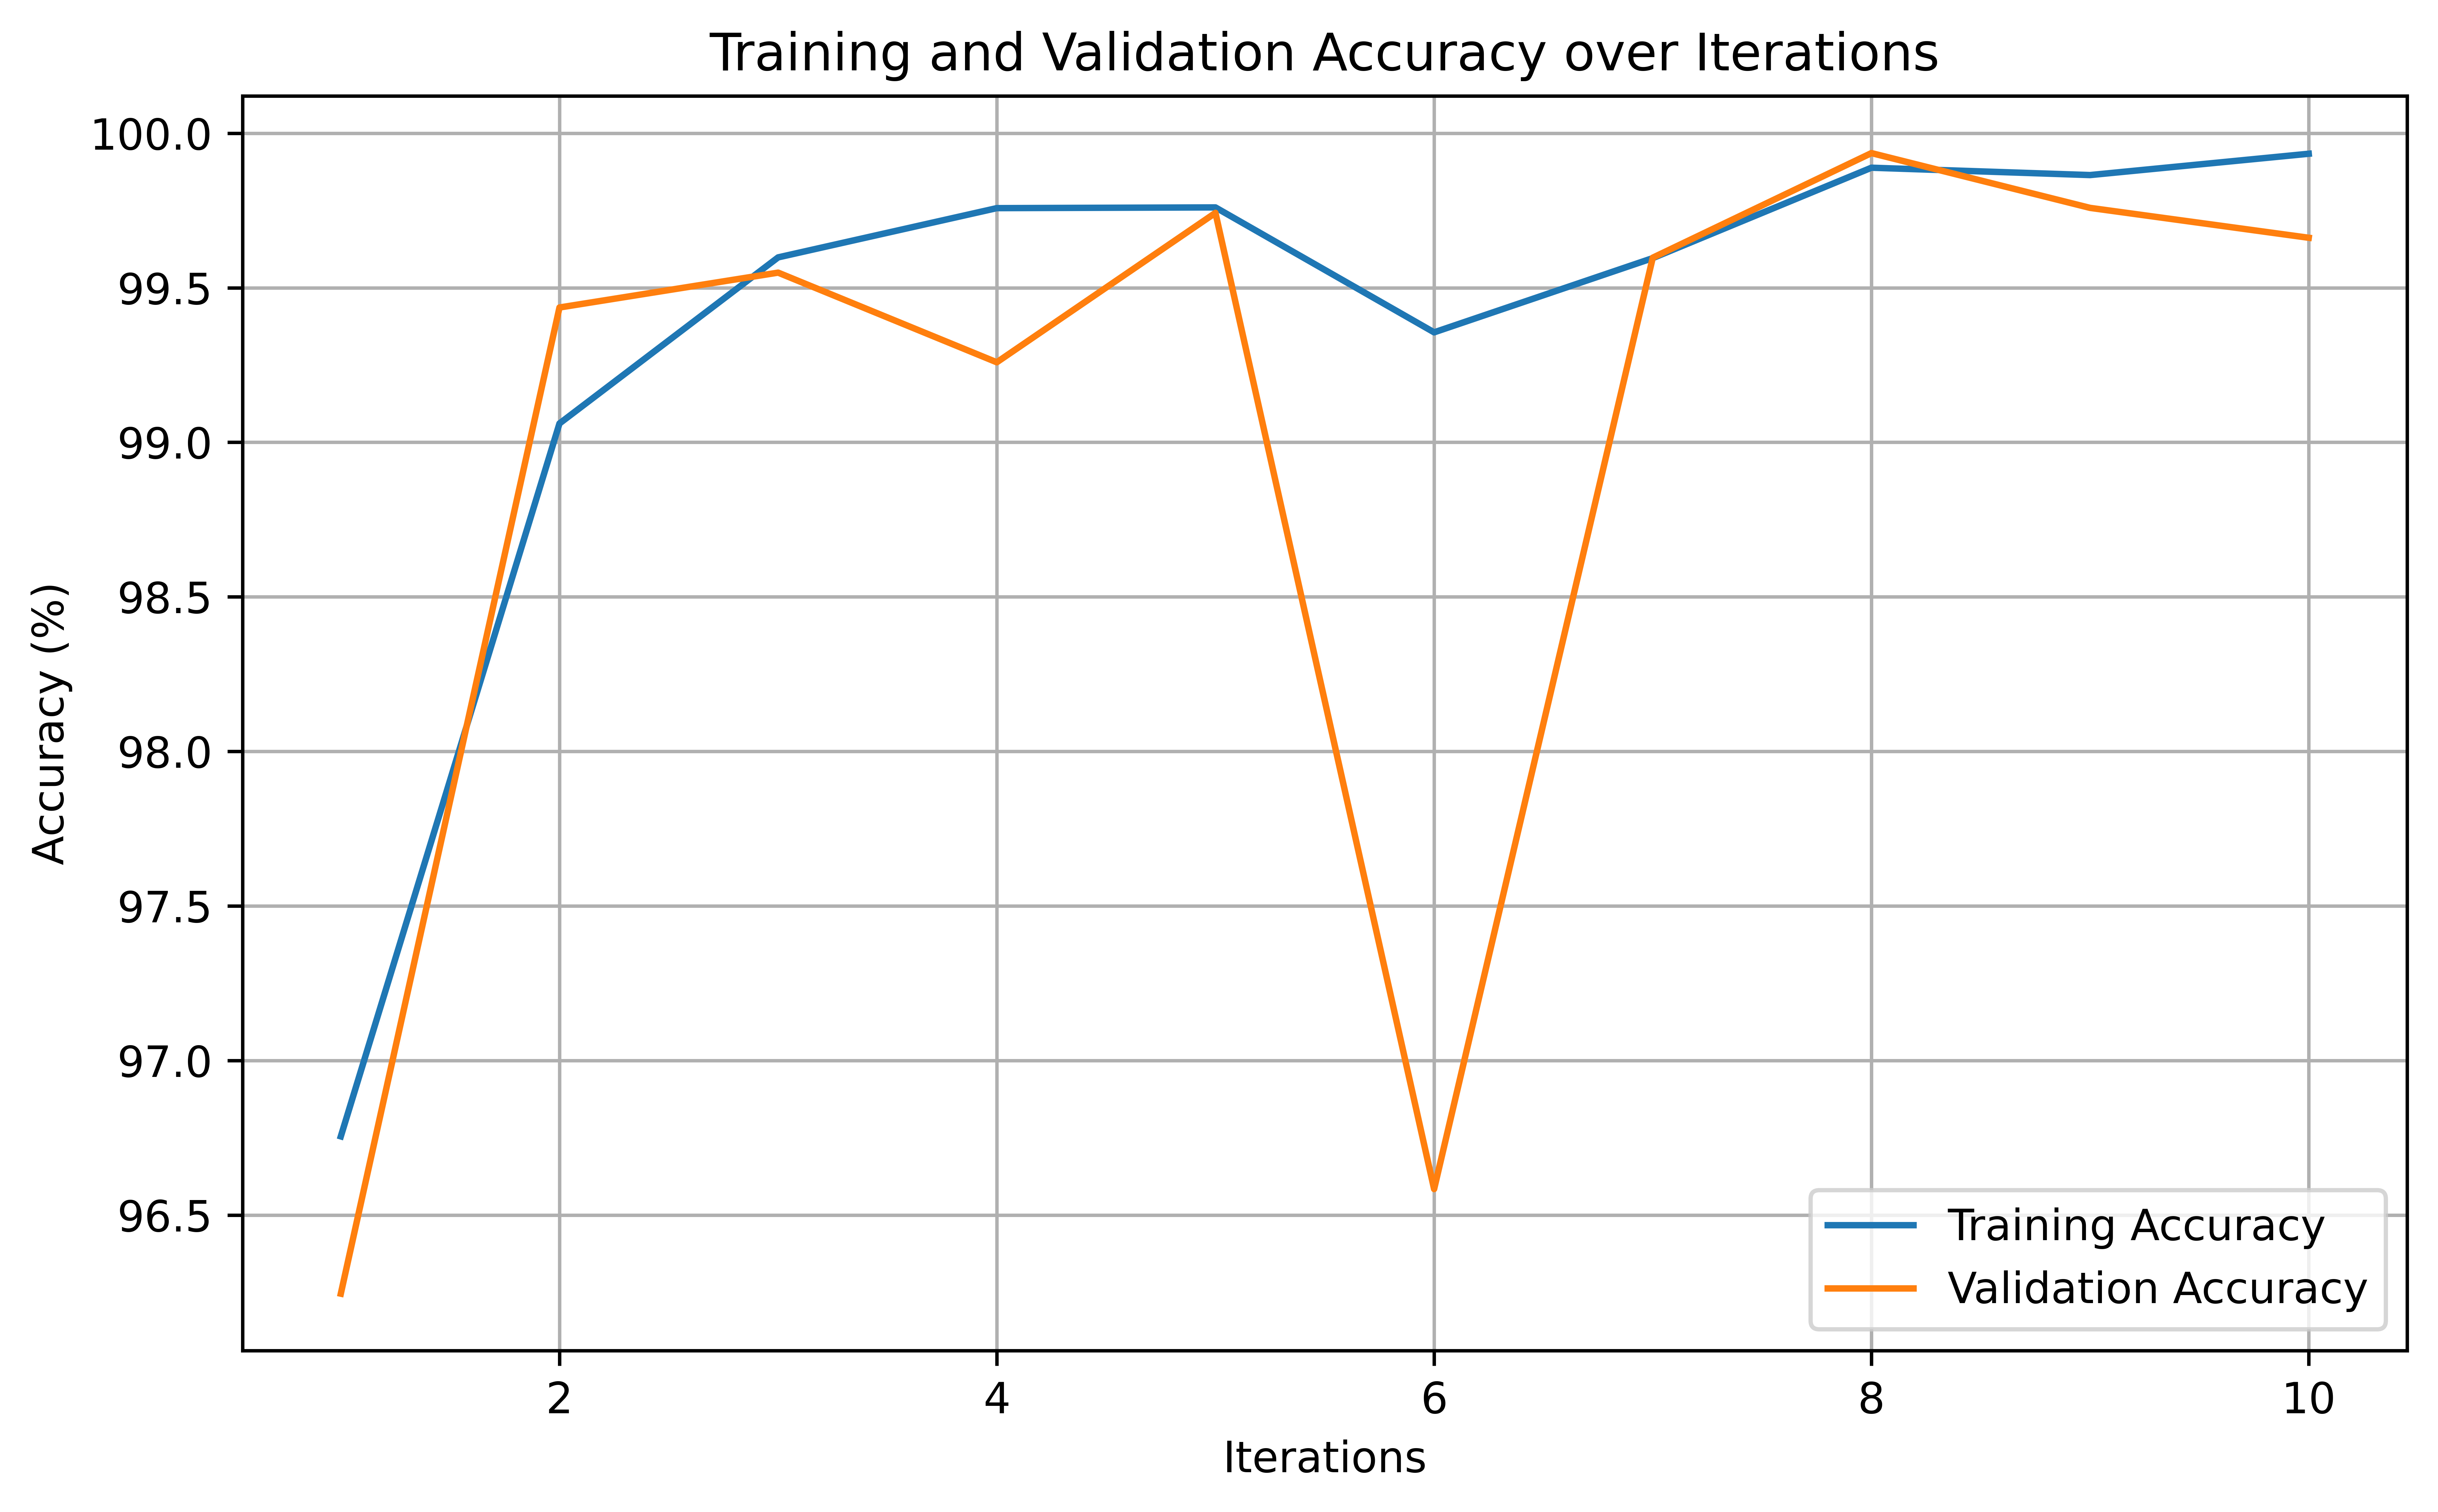

In [69]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(training_losses, validation_losses, training_accuracies, validation_accuracies):
    epochs = range(1, len(training_losses) + 1)

    # Plot for Training and Validation Loss
    plt.figure(figsize=(8, 5), dpi=1000)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot for Training and Validation Accuracy
    plt.figure(figsize=(8, 5), dpi=1000)
    plt.plot(epochs, training_accuracies, label='Training Accuracy')
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# After training
plot_training_history(model.training_losses, model.validation_losses, model.training_accuracies, model.validation_accuracies)


## TESTING WITH DIFFERENT ALPHA

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range of alpha and regularization_strength values
alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1]
reg_strength_values = [0.01, 0.05, 0.1, 0.5, 1.0]

# Define a constant value for the other hyperparameter
constant_reg_strength = 0.05  # Constant for the regularization strength
constant_alpha = 0.005  # Constant for the learning rate

# Store results for varying alpha
results_alpha = {'alpha': [], 'val_accuracy': [], 'val_loss': []}

# Loop to vary `alpha` while keeping `reg_strength` constant
for alpha in alpha_values:
    print(f"Training with alpha = {alpha}, regularization_strength = {constant_reg_strength}...")

    # Initialize the model with the current alpha and constant reg_strength
    model = LogisticRegression(
        positives=train_spam, negatives=train_ham, 
        public_key=public_key, val_pos=val_spam, val_neg=val_ham,
        iterations=10, alpha=alpha, regularization_strength=constant_reg_strength
    )

    # Evaluate the model on the validation set
    accuracy, avg_loss = model.evaluate(spam, ham)

    # Store the results
    results_alpha['alpha'].append(alpha)
    results_alpha['val_accuracy'].append(accuracy)
    results_alpha['val_loss'].append(avg_loss)

# Store results for varying regularization strength
results_reg_strength = {'reg_strength': [], 'val_accuracy': [], 'val_loss': []}

# Loop to vary `reg_strength` while keeping `alpha` constant
for reg_strength in reg_strength_values:
    print(f"Training with alpha = {constant_alpha}, regularization_strength = {reg_strength}...")

    # Initialize the model with the current reg_strength and constant alpha
    model = LogisticRegression(
        positives=train_spam, negatives=train_ham, 
        public_key=public_key, val_pos=val_spam, val_neg=val_ham,
        iterations=10, alpha=constant_alpha, regularization_strength=reg_strength
    )

    # Evaluate the model on the validation set
    accuracy, avg_loss = model.evaluate(spam, ham)

    # Store the results
    results_reg_strength['reg_strength'].append(reg_strength)
    results_reg_strength['val_accuracy'].append(accuracy)
    results_reg_strength['val_loss'].append(avg_loss)

# Plot for "Effect of Alpha on Accuracy and Loss"
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=1000)
axes[0].plot(results_alpha['alpha'], results_alpha['val_accuracy'], marker='o', color='b', label='Accuracy')
axes[0].set_xscale('log')
axes[0].set_title('Effect of Alpha on Accuracy')
axes[0].set_xlabel('Alpha (Learning Rate)')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(results_alpha['alpha'], results_alpha['val_loss'], marker='o', color='r', label='Loss')
axes[1].set_xscale('log')
axes[1].set_title('Effect of Alpha on Loss')
axes[1].set_xlabel('Alpha (Learning Rate)')
axes[1].set_ylabel('Validation Loss')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# Plot for "Effect of Reg Strength on Accuracy and Loss"
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=1000)
axes[0].plot(results_reg_strength['reg_strength'], results_reg_strength['val_accuracy'], marker='o', color='b', label='Accuracy')
axes[0].set_xscale('log')
axes[0].set_title('Effect of Reg Strength on Accuracy')
axes[0].set_xlabel('Regularization Strength')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(results_reg_strength['reg_strength'], results_reg_strength['val_loss'], marker='o', color='r', label='Loss')
axes[1].set_xscale('log')
axes[1].set_title('Effect of Reg Strength on Loss')
axes[1].set_xlabel('Regularization Strength')
axes[1].set_ylabel('Validation Loss')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


Training with alpha = 0.001, regularization_strength = 0.05...
Initializing Logistic Regression model...
Iteration: 1, Training Loss: 0.0828085106, Validation Loss: 0.0372160464, Training Accuracy: 95.14%, Validation Accuracy: 96.28%
Iteration: 2, Training Loss: 0.0420992908, Validation Loss: 0.0207829870, Training Accuracy: 98.30%, Validation Accuracy: 97.92%
Iteration: 3, Training Loss: 0.0358297872, Validation Loss: 0.0497825036, Training Accuracy: 98.62%, Validation Accuracy: 95.02%
Iteration: 4, Training Loss: 0.0384397163, Validation Loss: 0.0103109393, Training Accuracy: 98.34%, Validation Accuracy: 98.97%
Iteration: 5, Training Loss: 0.0433475177, Validation Loss: 0.0665377799, Training Accuracy: 97.93%, Validation Accuracy: 93.35%
Iteration: 6, Training Loss: 0.0281134752, Validation Loss: 0.1219590785, Training Accuracy: 99.16%, Validation Accuracy: 87.80%
Iteration: 7, Training Loss: 0.0311205674, Validation Loss: 0.0054776865, Training Accuracy: 99.00%, Validation Accuracy:

## TESTING WITH DIFFERENT REGULARIZATION STRENGTH

In [92]:
# Plot for "Effect of Alpha on Accuracy and Loss"
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=1000)
axes[0].plot(results_alpha['alpha'], results_alpha['val_accuracy'], marker='o', color='b', label='Accuracy')
axes[0].set_xscale('log')
axes[0].set_title('Effect of Alpha on Accuracy')
axes[0].set_xlabel('Alpha (Learning Rate)')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].legend()

axes[1].plot(results_alpha['alpha'], results_alpha['val_loss'], marker='o', color='r', label='Loss')
axes[1].set_xscale('log')
axes[1].set_title('Effect of Alpha on Loss')
axes[1].set_xlabel('Alpha (Learning Rate)')
axes[1].set_ylabel('Validation Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

# Plot for "Effect of Reg Strength on Accuracy and Loss"
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=1000)
axes[0].plot(results_reg_strength['reg_strength'], results_reg_strength['val_accuracy'], marker='o', color='b', label='Accuracy')
axes[0].set_xscale('log')
axes[0].set_title('Effect of Regularization Strength on Accuracy')
axes[0].set_xlabel('Regularization Strength')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].legend()

axes[1].plot(results_reg_strength['reg_strength'], results_reg_strength['val_loss'], marker='o', color='r', label='Loss')
axes[1].set_xscale('log')
axes[1].set_title('Effect of Regularization Strength on Loss')
axes[1].set_xlabel('Regularization Strength')
axes[1].set_ylabel('Validation Loss')
axes[1].legend()

plt.tight_layout()